**Problem Definition**

Classification of the weather image into one of the following classes

1. Sunrise
2. Shine
3. Rain
4. Cloudy

**Data**

[Dataset](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset)

1. The dataset contains images of corresponding to the Sunrise, Shine, Rain, Cloudy weather conditions
2. Class Distribution
    1. Sunrise - 357 
    2. Shine - 253
    3. Rain - 215
    4. Clody - 300
3. The updated folder structure of the dataset facilitate the data load prodecure
4. **Deleted rain141.jpg(data/Weather/Train/Rain/rain141.jpg) as it is giving error when using `tf.decode_jpeg`**

Data Publication
1. The dataset was published on [Mendeley Data](https://data.mendeley.com/datasets/4drtyfjtfy/1)
2. Cite: Ajayi, Gbeminiyi (2018), Multi-class Weather Dataset for Image Classification, Mendeley Data, v1
3. [DOI](http://dx.doi.org/10.17632/4drtyfjtfy.1)
4. Published: 2018-09-13
5. Institutions: University of South Africa - Science Campus
6. Licence: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)


**Evaluation**

Accuracy

**Modelling**

Fully Convolutional Network (FCN)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Importing necessary libraries

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import math
import shutil
import pickle
import matplotlib.pyplot as plt
import itertools

In [ ]:
# Splitting the data into train(80%), validation(10%), test(10%)

source_path = 'data/Weather'
classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

for weather_class in classes:
    os.makedirs(source_path + '/Train/' + weather_class)
    os.makedirs(source_path + '/Val/' + weather_class)
    os.makedirs(source_path + '/Test/' + weather_class)
    
    file_names = os.listdir(source_path + '/' + weather_class)
    np.random.shuffle(file_names)
    
    train_file_names, val_file_names, test_file_names = np.split(file_names, [int(len(file_names) * (0.8)), int(len(file_names) * (0.9))])
    
    train_file_names = [source_path + '/' + weather_class + '/' + name for name in train_file_names.tolist()]
    val_file_names = [source_path + '/' + weather_class + '/' + name for name in val_file_names.tolist()]
    test_file_names = [source_path + '/' + weather_class + '/' + name for name in test_file_names.tolist()]
    
    
    for name in train_file_names:
        shutil.move(name, source_path + '/train/' + weather_class)
        
    for name in val_file_names:
        shutil.move(name, source_path + '/val/' + weather_class)
        
    for name in test_file_names:
        shutil.move(name, source_path + '/test/' + weather_class)
        
    shutil.rmtree(source_path + '/' + weather_class)

# Initial End-to-End Workflow (Start)

## Using keras `image_dataset_from_directory`

In [ ]:
# tf.keras.utils.image_dataset_from_directory is reshaping the data

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     'data/Weather/Train',
#     batch_size=None
# )

It resizes the image while loading from the respective directories

## Using `tf.data.Dataset`

In [3]:
train_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Train/*/*')

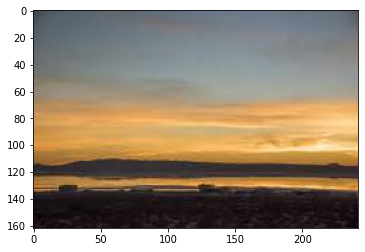

In [4]:
raw = tf.io.read_file('/content/drive/MyDrive/FCN/data/Weather/Train/Sunrise/sunrise304.jpg')
img = tf.image.decode_jpeg(raw, channels=3)
plt.imshow(img)

In [5]:
tf.equal(tf.constant(b'Cloudy', dtype='string'), b'Cloudy')

<tf.Tensor: shape=(), dtype=bool, numpy=True>

Minimum Aspect Ratio (Height/Width) of images must be greater than 0.4 for producing better resized images

In [6]:
label_map = {b'Cloudy': tf.constant([1, 0, 0, 0]), 
             b'Rain': tf.constant([0, 1, 0, 0]), 
             b'Shine': tf.constant([0, 0, 1, 0]), 
             b'Sunrise': tf.constant([0, 0, 0, 1])}

f0 = lambda : tf.constant([1, 0, 0, 0])
f1 = lambda : tf.constant([0, 1, 0, 0])
f2 = lambda : tf.constant([0, 0, 1, 0])
f3 = lambda : tf.constant([0, 0, 0, 1])

def get_image_label(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    
    label_int = tf.case([(tf.equal(label, b'Cloudy'), f0),
                         (tf.equal(label, b'Rain'), f1),
                         (tf.equal(label, b'Shine'), f2),
                         (tf.equal(label, b'Sunrise'), f3)
                        ])
    
    raw = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = img/255
    
    if (tf.shape(img)[0] < 150 or tf.shape(img)[1] < 150):
        img = tf.image.resize(img, [256, 256], preserve_aspect_ratio=True) # 256(W) * 0.4 = 102.4 
        
    return img, label_int

In [7]:
train_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Train/*/*')
val_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Val/*/*')
test_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Test/*/*')

train_labeled_ds = train_ds.map(get_image_label)
val_labeled_ds = val_ds.map(get_image_label)
test_labeled_ds = test_ds.map(get_image_label)

In [8]:
for i in train_labeled_ds.take(1):
    sample_inst = i

(<matplotlib.image.AxesImage at 0x7fbe0dfd9190>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 0, 0, 0], dtype=int32)>)

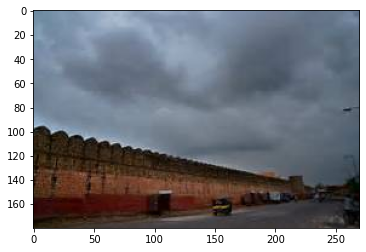

In [9]:
plt.imshow(sample_inst[0]), sample_inst[1]

In [10]:
sample_inst[0].shape, sample_inst[1].shape

(TensorShape([180, 270, 3]), TensorShape([4]))

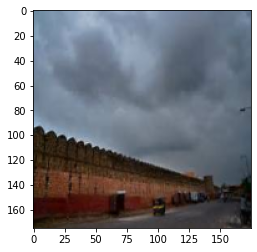

In [11]:
plt.imshow(tf.image.resize(sample_inst[0], [175, 175]))

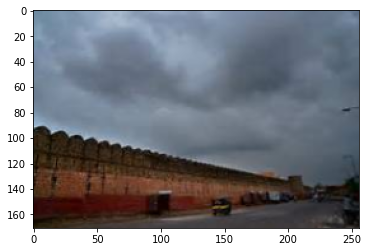

In [12]:
plt.imshow(tf.image.resize(sample_inst[0], [256, 256], preserve_aspect_ratio=True))

In [13]:
# Define the FCN

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(None, None, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(4, (1, 1), padding='valid'))
model.add(keras.layers.GlobalMaxPool2D())
model.add(keras.layers.Activation('softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 32)    9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                    

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
save_best_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data', save_best_only=True) # Saves the best model so far

In [17]:
n_epochs = 3

train_labeled_ds_batch = train_labeled_ds.shuffle(train_labeled_ds.cardinality().numpy(), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)
val_labeled_ds_batch = val_labeled_ds.shuffle(val_labeled_ds.cardinality().numpy(), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)
test_labeled_ds_batch = test_labeled_ds.shuffle(test_labeled_ds.cardinality().numpy(), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)

In [18]:
steps_per_epoch = train_labeled_ds.cardinality().numpy()
validation_steps = val_labeled_ds.cardinality().numpy()

In [ ]:
history = model.fit(train_labeled_ds_batch, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_labeled_ds_batch, validation_steps=validation_steps, callbacks=[save_best_cb])

Epoch 1/3
892/898 [============================>.] - ETA: 0s - loss: 1.1195 - accuracy: 0.5067INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data/assets


898/898 [==============================] - 37s 36ms/step - loss: 1.1181 - accuracy: 0.5067 - val_loss: 0.9099 - val_accuracy: 0.5536
Epoch 2/3
895/898 [============================>.] - ETA: 0s - loss: 0.9229 - accuracy: 0.5832INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data/assets


898/898 [==============================] - 37s 36ms/step - loss: 0.9233 - accuracy: 0.5835 - val_loss: 0.8268 - val_accuracy: 0.5446
Epoch 3/3
896/898 [============================>.] - ETA: 0s - loss: 0.8866 - accuracy: 0.6328INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data/assets


898/898 [==============================] - 37s 36ms/step - loss: 0.8861 - accuracy: 0.6336 - val_loss: 0.7526 - val_accuracy: 0.7143


In [ ]:
history.history

{'accuracy': [0.506681501865387, 0.583518922328949, 0.6336302757263184],
 'loss': [1.1180700063705444, 0.9232985377311707, 0.8860755562782288],
 'val_accuracy': [0.5535714030265808, 0.5446428656578064, 0.7142857313156128],
 'val_loss': [0.9098654985427856, 0.8268290758132935, 0.7526450753211975]}

In [ ]:
with open('/content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data-history', 'wb') as history_file:
    pickle.dump(history.history, history_file)

In [ ]:
tf_best_model = keras.models.load_model('/content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data')
tf_history = np.load('/content/drive/MyDrive/FCN/models/initial-end-to-end-tf-data-history', allow_pickle=True)

In [ ]:
tf_history

{'accuracy': [0.506681501865387, 0.583518922328949, 0.6336302757263184],
 'loss': [1.1180700063705444, 0.9232985377311707, 0.8860755562782288],
 'val_accuracy': [0.5535714030265808, 0.5446428656578064, 0.7142857313156128],
 'val_loss': [0.9098654985427856, 0.8268290758132935, 0.7526450753211975]}

In [ ]:
steps = test_labeled_ds.cardinality().numpy()
tf_best_model.evaluate(test_labeled_ds_batch, steps=steps)

114/114 [==============================] - 3s 17ms/step - loss: 0.7590 - accuracy: 0.7105


[0.759046196937561, 0.7105262875556946]

## Using keras `Sequence`

In [19]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_arr, y_arr, batch_size=32, shuffle=True):
        # x_arr: Image file paths
        # y_arr: Labels
        
        self.x_arr = x_arr
        self.y_arr = y_arr
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x_arr))
        np.random.shuffle(self.indexes)
        
    def preprocess_images(self, x_arr):
        images = []
        max_shape = [1, 1]
        for image in x_arr:
            image = tf.io.read_file(image)
            image = tf.image.decode_jpeg(image, channels=3)
            image = image/255
            max_shape[0] = max(max_shape[0], tf.shape(image)[0])
            max_shape[1] = max(max_shape[1], tf.shape(image)[1])
            images.append(image)
        max_shape[0] = min(256, max_shape[0])
        max_shape[1] = min(256, max_shape[1])
        
        X = np.zeros((self.batch_size, max_shape[0], max_shape[1], 3))
        
        for i, image in enumerate(images):
            image = tf.image.resize(image, [max_shape[0], max_shape[1]], preserve_aspect_ratio=True)
            start_height = ((X.shape[1] - image.shape[0])//2)
            start_width = (X.shape[2] - image.shape[1])//2
            X[i, start_height: start_height + image.shape[0], start_width: start_width + image.shape[1], :image.shape[2]] = image
        
        return X
            
        
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.preprocess_images(self.x_arr[indexes])
        y = np.array(self.y_arr[indexes])
        
        return X, y
    
    def __len__(self):
        return math.floor(len(self.x_arr) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [ ]:
root_path = '/content/drive/MyDrive/FCN/data/Weather'
file_names_map = {}
file_labels_map = {'Train': [], 'Val': [], 'Test': []}
labels_map = {'Cloudy': np.array([1.0, 0, 0, 0]), 
              'Rain': np.array([0, 1.0, 0, 0]), 
              'Shine': np.array([0, 0, 1.0, 0]), 
              'Sunrise': np.array([0, 0, 0, 1.0])}
    

for i in ['Train', 'Val', 'Test']:
    files_i = []
    for label in os.listdir(root_path + '/' + i):
        file_paths = os.listdir(root_path + '/' + i + '/' + label)
        file_paths = list(map(lambda file_path: root_path + '/' + i + '/' + label + '/' + file_path, file_paths))
        file_paths = list(filter(lambda file_path: file_path.endswith('.jpg') or file_path.endswith('.jpeg'), file_paths))

        file_labels_map[i].extend([labels_map[label] for _ in range(len(file_paths))])
        
        files_i.extend(file_paths)
    
    file_names_map[i] = files_i

In [ ]:
train_x = np.array(file_names_map['Train'])
train_y = np.array(file_labels_map['Train'])

val_x = np.array(file_names_map['Val'])
val_y = np.array(file_labels_map['Val'])

test_x = np.array(file_names_map['Test'])
test_y = np.array(file_labels_map['Test'])

In [ ]:
train_gen = DataGenerator(train_x, train_y, batch_size=8)
val_gen = DataGenerator(val_x, val_y, batch_size=8)
test_gen = DataGenerator(test_x, test_y, batch_size=8)

In [ ]:
# Define the FCN

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(None, None, 3)))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(4, (1, 1), padding='valid'))
model.add(keras.layers.GlobalMaxPool2D())
model.add(keras.layers.Activation('softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
save_best_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence', save_best_only=True) # Saves the best model so far

In [ ]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

In [ ]:
history = model.fit(train_gen, epochs=3, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps, callbacks=[save_best_cb])

Epoch 1/3
112/112 [==============================] - ETA: 0s - loss: 1.2718 - accuracy: 0.3739INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence/assets


112/112 [==============================] - 258s 2s/step - loss: 1.2718 - accuracy: 0.3739 - val_loss: 1.0977 - val_accuracy: 0.5179
Epoch 2/3
112/112 [==============================] - ETA: 0s - loss: 1.1487 - accuracy: 0.4554INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence/assets


112/112 [==============================] - 16s 147ms/step - loss: 1.1487 - accuracy: 0.4554 - val_loss: 1.0685 - val_accuracy: 0.5357
Epoch 3/3
112/112 [==============================] - 13s 118ms/step - loss: 1.0571 - accuracy: 0.5301 - val_loss: 1.0797 - val_accuracy: 0.4554


In [ ]:
history.history

{'accuracy': [0.3738839328289032, 0.4553571343421936, 0.5301339030265808],
 'loss': [1.2718470096588135, 1.1487170457839966, 1.0571006536483765],
 'val_accuracy': [0.5178571343421936, 0.5357142686843872, 0.4553571343421936],
 'val_loss': [1.0976955890655518, 1.068494200706482, 1.0796599388122559]}

Clearly the model is overfitting (Train Accuracy is increasing, Validation Accuracy is decreasing)

In [ ]:
with open('/content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence-history', 'wb') as history_file:
    pickle.dump(history.history, history_file)

1. OOM Error if we are not bouding the maximum height or width of the image
2. If you use math.ceil in DataGenerator `__len__` method you can train the model using the following code

<pre>
for i in range(num_batches):
  print(i)
  a = train_gen[i]
  model.train_on_batch(a[0], a[1])
</pre>

In [ ]:
keras_best_model = keras.models.load_model('/content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence')
keras_history = np.load('/content/drive/MyDrive/FCN/models/initial-end-to-end-keras-sequence-history', allow_pickle=True)

In [ ]:
keras_history

{'accuracy': [0.3738839328289032, 0.4553571343421936, 0.5301339030265808],
 'loss': [1.2718470096588135, 1.1487170457839966, 1.0571006536483765],
 'val_accuracy': [0.5178571343421936, 0.5357142686843872, 0.4553571343421936],
 'val_loss': [1.0976955890655518, 1.068494200706482, 1.0796599388122559]}

In [ ]:
steps = len(test_gen)
keras_best_model.evaluate(test_gen, steps=steps)

14/14 [==============================] - 2s 156ms/step - loss: 1.1443 - accuracy: 0.4286


[1.1443489789962769, 0.4285714328289032]

# Initial End-to-End Workflow (End)

# Modelling the FCN

### Useful Functions

In [2]:
# Defining a function the get the training and validation plots representing the accuracy and loss at each epoch
def get_train_val_plots(h, yticks=None, figsize=(10, 5)):
    # h: Any dictionary like the history.history
    
    fig, ax = plt.subplots(figsize=figsize)
    n_epochs = len(h['loss'])
    x_loss = np.arange(n_epochs+1)-0.5
    
    ax.plot(x_loss[x_loss >= 0], h['loss'], color='b', label='train_loss')
    ax.plot(range(1, n_epochs+1), h['val_loss'], color='r', label='val_loss')
    ax.plot(range(1, n_epochs+1), h['accuracy'], color='b', label='train_accuracy', linestyle='--')
    ax.plot(range(1, n_epochs+1), h['val_accuracy'], color='r', label='val_accuracy', linestyle='--')
    ax.set_xlim(0, n_epochs)
    ax.set_xticks(range(1, n_epochs+1))
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.legend()

Training images without resizing i.e, using the original images without any changes using the `tf.data` API

In [3]:
label_map = {b'Cloudy': tf.constant([1, 0, 0, 0]), 
             b'Rain': tf.constant([0, 1, 0, 0]), 
             b'Shine': tf.constant([0, 0, 1, 0]), 
             b'Sunrise': tf.constant([0, 0, 0, 1])}

f0 = lambda : tf.constant([1, 0, 0, 0])
f1 = lambda : tf.constant([0, 1, 0, 0])
f2 = lambda : tf.constant([0, 0, 1, 0])
f3 = lambda : tf.constant([0, 0, 0, 1])

def get_image_label(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    
    label_int = tf.case([(tf.equal(label, b'Cloudy'), f0),
                         (tf.equal(label, b'Rain'), f1),
                         (tf.equal(label, b'Shine'), f2),
                         (tf.equal(label, b'Sunrise'), f3)
                        ])
    
    raw = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(raw, channels=3)
    img = img/255
    
    if (tf.shape(img)[0] < 150 or tf.shape(img)[1] < 150):
        img = tf.image.resize(img, [256, 256], preserve_aspect_ratio=True) # 256(W) * 0.4 = 102.4 
        
    return img, label_int

In [4]:
train_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Train/*/*')
val_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Val/*/*')
test_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/FCN/data/Weather/Test/*/*')

train_labeled_ds = train_ds.map(get_image_label)
val_labeled_ds = val_ds.map(get_image_label)
test_labeled_ds = test_ds.map(get_image_label)

In [5]:
n_epochs = 2

train_labeled_ds_batch = train_labeled_ds.shuffle(train_labeled_ds.cardinality().numpy(), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)
val_labeled_ds_batch = val_labeled_ds.shuffle(val_labeled_ds.cardinality().numpy(), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)
test_labeled_ds_batch = test_labeled_ds.shuffle(test_labeled_ds.cardinality().numpy(), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)

steps_per_epoch = train_labeled_ds.cardinality().numpy()
validation_steps = val_labeled_ds.cardinality().numpy()

In [6]:
train_cloudy_len = len(list(os.listdir('/content/drive/MyDrive/FCN/data/Weather/Train/Cloudy')))
train_rain_len = len(list(os.listdir('/content/drive/MyDrive/FCN/data/Weather/Train/Rain')))
train_shine_len = len(list(os.listdir('/content/drive/MyDrive/FCN/data/Weather/Train/Shine')))
train_sunrise_len = len(list(os.listdir('/content/drive/MyDrive/FCN/data/Weather/Train/Sunrise')))

train_label_lengths = [train_cloudy_len, train_rain_len, train_shine_len, train_sunrise_len]
train_length = sum(train_label_lengths)
train_label_props = list(map(lambda x: round(x/train_length, 2), train_label_lengths))

train_label_props

[0.27, 0.19, 0.22, 0.32]

In [7]:
def get_stratified_folds(labels, root_dir, n=5):
  # labels : List
  # root_dir: String

  label_files = []
  for label in labels:
    label_df = tf.data.Dataset.list_files(root_dir + '/' + label + '/*')
    label_files.append(label_df.shuffle(label_df.cardinality().numpy()))

  stratified_folds = [None]*n
    
  for tf_df in label_files:
    increment = len(tf_df)//n

    if stratified_folds[0] is None:
      stratified_folds = [tf_df.skip(i*increment).take(increment) for i in range(n)]
    else:
      stratified_folds = [stratified_folds[i].concatenate(tf_df.skip(i*increment).take(increment)) for i in range(n)]

    if len(tf_df) % n != 0:
      stratified_folds[-1] = stratified_folds[-1].concatenate(tf_df.skip(increment*n).take(n))
  
  return stratified_folds

In [8]:
def preprocess_tf_data():
    label_map = {b'Cloudy': tf.constant([1, 0, 0, 0]), 
                 b'Rain': tf.constant([0, 1, 0, 0]), 
                 b'Shine': tf.constant([0, 0, 1, 0]), 
                 b'Sunrise': tf.constant([0, 0, 0, 1])}

    f0 = lambda : tf.constant([1, 0, 0, 0])
    f1 = lambda : tf.constant([0, 1, 0, 0])
    f2 = lambda : tf.constant([0, 0, 1, 0])
    f3 = lambda : tf.constant([0, 0, 0, 1])

    def get_image_label(file_path):
        label = tf.strings.split(file_path, os.sep)[-2]
        
        label_int = tf.case([(tf.equal(label, b'Cloudy'), f0),
                            (tf.equal(label, b'Rain'), f1),
                            (tf.equal(label, b'Shine'), f2),
                            (tf.equal(label, b'Sunrise'), f3)
                            ])
        
        raw = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(raw, channels=3)
        img = img/255
        
        if (tf.shape(img)[0] < 150 or tf.shape(img)[1] < 150):
            img = tf.image.resize(img, [256, 256], preserve_aspect_ratio=True) # 256(W) * 0.4 = 102.4 
            
        return img, label_int
    return get_image_label

In [9]:
def perform_stratified_cross_validation(build_model_fn, model_params, labels, root_dir, n=5, n_epochs=2):
    # n: Number of folds
    # n_epochs: FCN training epochs

    stratified_folds = get_stratified_folds(labels, root_dir, n)
    cross_val_results = []

    for i in range(n):
        train = stratified_folds[:i] + stratified_folds[i+1:]
        test_ds = stratified_folds[i]

        train_ds = train[0]

        for ds in train[1:]:
            train_ds = train_ds.concatenate(ds)

        train_labeled_ds = train_ds.map(preprocess_tf_data())
        test_labeled_ds = test_ds.map(preprocess_tf_data())

        train_labeled_ds_batch = train_labeled_ds.shuffle(len(train_labeled_ds), reshuffle_each_iteration=True).batch(1).repeat(n_epochs)
        test_labeled_ds_batch = test_labeled_ds.shuffle(len(test_labeled_ds), reshuffle_each_iteration=True).batch(1)

        steps_per_epoch = len(train_labeled_ds)

        model = build_model_fn(**model_params)
        history = model.fit(train_labeled_ds_batch, epochs=n_epochs, steps_per_epoch=steps_per_epoch)

        steps = len(test_labeled_ds)
        test_results = model.evaluate(test_labeled_ds_batch, steps=steps)
        cross_val_results.append(test_results)

    return cross_val_results

In [10]:
# Test Run for perform_stratified_cross_validation

def build_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(None, None, 3)))
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(keras.layers.Conv2D(4, (1, 1), padding='valid'))
    model.add(keras.layers.GlobalMaxPool2D())
    model.add(keras.layers.Activation('softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cross_val_results = perform_stratified_cross_validation(build_model, {}, ['Cloudy', 'Rain', 'Shine', 'Sunrise'], '/content/drive/MyDrive/FCN/data/Weather/Train')

Epoch 1/2
719/719 [==============================] - 413s 508ms/step - loss: 1.2059 - accuracy: 0.4089
Epoch 2/2
179/179 [==============================] - 16s 73ms/step - loss: 0.8635 - accuracy: 0.6536
Epoch 1/2
719/719 [==============================] - 73s 85ms/step - loss: 1.1890 - accuracy: 0.4590
Epoch 2/2
179/179 [==============================] - 5s 15ms/step - loss: 0.8700 - accuracy: 0.5866
Epoch 1/2
719/719 [==============================] - 31s 37ms/step - loss: 1.1819 - accuracy: 0.4701
Epoch 2/2
179/179 [==============================] - 4s 15ms/step - loss: 0.8306 - accuracy: 0.5810
Epoch 1/2
719/719 [==============================] - 26s 30ms/step - loss: 1.2106 - accuracy: 0.4729
Epoch 2/2
179/179 [==============================] - 4s 15ms/step - loss: 1.0689 - accuracy: 0.5754
Epoch 1/2
716/716 [==============================] - 26s 30ms/step - loss: 1.3050 - accuracy: 0.3925
Epoch 2/2
182/182 [==============================] - 6s 22ms/step - loss: 0.9681 - accuracy:

In [15]:
cross_val_results

[[0.8635208010673523, 0.6536312699317932],
 [0.8699933886528015, 0.5865921974182129],
 [0.8305886387825012, 0.5810055732727051],
 [1.0688945055007935, 0.575419008731842],
 [0.9680598974227905, 0.6043956279754639]]

In [16]:
avg_acc = np.average(cross_val_results, axis=0)[1]

In [17]:
avg_acc

0.6002087354660034